# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups            
Sample_012  Q6ZMI3                       15.734
Sample_026  A0A1B0GUU9;P01871;P01871-2   17.607
Sample_150  E7ETH0;G3XAM2;P05156         19.533
Sample_197  H7C2F2                       19.628
Sample_092  A0A0A0MQU6;Q9H2E6;Q9H2E6-2   16.121
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                        
Sample_178  A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2   14.464
Sample_200  P05109                                                   13.759
Sample_191  P09960;P09960-4                                          13.700
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.308
            A0A075B6Q5                 13.441
            A0A075B6R2                 13.623
            A0A075B6S5                 13.490
            A0A087WSY4                 13.192
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.223
            Q9UI40;Q9UI40-2            12.219
            Q9UIW2                     13.461
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.057
            Q9UP79                     12.802
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.633,15.050,16.842,19.863,15.639,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.177,19.067,...,15.528,15.576,13.709,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.521,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.756,17.705,17.039,16.567,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.778,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.365,15.345,17.084,18.708,14.249,19.433,11.816,11.199
Sample_207,15.739,16.877,15.469,16.898,15.154,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.383,13.422,13.378,12.301,12.493,12.850,12.985,13.489,14.003,12.120
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.808,19.067,16.127,...,13.937,11.614,11.988,13.296,12.808,13.041,12.507,12.665,12.588,12.533
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.205,12.426,12.998,13.725,12.870,13.280,12.433,13.031,12.321,12.610
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.216,11.698,12.944,14.084,12.917,12.488,12.317,12.438,13.343,13.354
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.150,12.692,13.146,12.385,14.552,13.435,11.946,13.903,12.507,13.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.617,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 385.51it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.58it/s]

100%|██████████| 2/2 [00:00<00:00,  7.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.53it/s]

100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.19it/s]

100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

100%|██████████| 4/4 [00:00<00:00,  4.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.24it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.59it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.85it/s]

100%|██████████| 5/5 [00:01<00:00,  4.32it/s]

100%|██████████| 5/5 [00:01<00:00,  4.78it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.32it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.11it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.15it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.91it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.18it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.41it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.96it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.82it/s]

100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.86it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.42it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.40it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.05it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.93it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.99it/s]

100%|██████████| 8/8 [00:01<00:00,  3.89it/s]

100%|██████████| 8/8 [00:01<00:00,  4.24it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.35it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.25it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.65it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.23it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.12it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.90it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.93it/s]

100%|██████████| 9/9 [00:02<00:00,  3.93it/s]

100%|██████████| 9/9 [00:02<00:00,  4.25it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.33it/s]

 30%|███       | 3/10 [00:00<00:01,  4.81it/s]

 40%|████      | 4/10 [00:00<00:01,  4.30it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.04it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.83it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.70it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.68it/s]

100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.01it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.13it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.52it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.20it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.07it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.96it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.03it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.77it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.98it/s]

100%|██████████| 11/11 [00:02<00:00,  4.05it/s]

100%|██████████| 11/11 [00:02<00:00,  4.22it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.20it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.71it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.93it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.52it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.33it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.50it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.27it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.03it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.97it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.98it/s]

100%|██████████| 12/12 [00:02<00:00,  3.93it/s]

100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.48it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.24it/s]

 31%|███       | 4/13 [00:01<00:02,  3.65it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.33it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.22it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.09it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.07it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.01it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.92it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.88it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.96it/s]

100%|██████████| 13/13 [00:03<00:00,  3.30it/s]

100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.62it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.49it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.91it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.85it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.84it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.75it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.49it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.65it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.42it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.64it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.73it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.78it/s]

100%|██████████| 14/14 [00:03<00:00,  3.62it/s]

100%|██████████| 14/14 [00:03<00:00,  3.75it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.35it/s]

 20%|██        | 3/15 [00:00<00:02,  4.08it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.51it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.29it/s]

 40%|████      | 6/15 [00:01<00:02,  3.07it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.95it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.97it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.11it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.28it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.26it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.33it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.39it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.39it/s]

100%|██████████| 15/15 [00:04<00:00,  3.54it/s]

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.033 0.007          0.706 0.393       0.107   
2             0.003 0.000      0.035 0.001          0.709 0.090       0.601   
3             0.003 0.000      0.035 0.001          0.720 0.085       0.659   
4             0.003 0.002      0.035 0.001          0.702 0.077       0.668   
5             0.003 0.001      0.034 0.003          0.728 0.090       0.692   
6             0.003 0.000      0.035 0.005          0.800 0.092       0.812   
7             0.003 0.000      0.035 0.001          0.802 0.085       0.826   
8             0.004 0.000      0.035 0.002          0.827 0.085       0.816   
9             0.003 0.000      0.034 0.001          0.824 0.084       0.824   
10            0.003 0.002      0.034 0.012          0.833 0.081       0.828   
11            0.003 0.000      0.036 0.012          0.826 0.076       0.831   
12            0.004 0.004      0.038 0.008          0.820 0.076       0.815   
13            0.004 0.002      0.034 0.006          0.815 0.080       0.816   
14            0.005 0.005      0.048 0.019          0.816 0.082       0.815   
15            0.004 0.002      0.042 0.015          0.822 0.084       0.825   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.180 0.133                  0.546 0.042        0.848   
2          0.102   0.645 0.078                  0.708 0.058        0.780   
3          0.113   0.681 0.081                  0.734 0.060        0.801   
4          0.112   0.678 0.073                  0.728 0.055        0.799   
5          0.117   0.702 0.078                  0.749 0.060        0.809   
6          0.108   0.801 0.075                  0.830 0.065        0.895   
7          0.102   0.809 0.069                  0.836 0.059        0.895   
8          0.106   0.817 0.073                  0.844 0.062        0.910   
9          0.097   0.820 0.067                  0.846 0.057        0.909   
10         0.098   0.826 0.065                  0.852 0.056        0.914   
11         0.104   0.824 0.069                  0.850 0.059        0.914   
12         0.104   0.813 0.066                  0.841 0.056        0.912   
13         0.098   0.812 0.067                  0.839 0.058        0.911   
14         0.099   0.811 0.069                  0.839 0.060        0.909   
15         0.097   0.819 0.065                  0.845 0.055        0.912   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.088        210.000 0.000  
2          0.068                  0.758 0.085        210.000 0.000  
3          0.065                  0.767 0.087        210.000 0.000  
4          0.061                  0.761 0.083        210.000 0.000  
5          0.060                  0.779 0.081        210.000 0.000  
6          0.052                  0.869 0.061        210.000 0.000  
7          0.050                  0.868 0.059        210.000 0.000  
8          0.050                  0.900 0.050        210.000 0.000  
9          0.050                  0.899 0.051        210.000 0.000  
10         0.049                  0.900 0.055        210.000 0.000  
11         0.049                  0.899 0.054        210.000 0.000  
12         0.049                  0.898 0.053        210.000 0.000  
13         0.050                  0.896 0.054        210.000 0.000  
14         0.051                  0.893 0.056        210.000 0.000  
15         0.049                  0.901 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 551.01it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.16it/s]

100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.86it/s]

100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.47it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.10it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.06it/s]

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.05it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  2.81it/s]

100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.83it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.36it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.00it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.81it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.68it/s]

100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.90it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.17it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.17it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.19it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.29it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.30it/s]

100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.53it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.22it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.10it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.22it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.18it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.21it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.21it/s]

100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.91it/s]

 30%|███       | 3/10 [00:00<00:01,  3.97it/s]

 40%|████      | 4/10 [00:01<00:01,  3.51it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.54it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.44it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.24it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.13it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.17it/s]

100%|██████████| 10/10 [00:02<00:00,  3.11it/s]

100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.01it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.32it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.88it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.36it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.26it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.31it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.37it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.37it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.35it/s]

100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

100%|██████████| 11/11 [00:03<00:00,  3.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.14it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.73it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.38it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.21it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.12it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.30it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.21it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.23it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.30it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.34it/s]

100%|██████████| 12/12 [00:03<00:00,  3.27it/s]

100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.31it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.61it/s]

 31%|███       | 4/13 [00:00<00:02,  4.01it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.21it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.99it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.84it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.68it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.42it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.21it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.44it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.52it/s]

100%|██████████| 13/13 [00:04<00:00,  2.74it/s]

100%|██████████| 13/13 [00:04<00:00,  2.86it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.31it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.96it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.69it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.55it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.35it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.08it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.09it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.11it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.16it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.91it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.67it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.52it/s]

100%|██████████| 14/14 [00:04<00:00,  2.35it/s]

100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.17it/s]

 20%|██        | 3/15 [00:00<00:03,  3.17it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.59it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.43it/s]

 40%|████      | 6/15 [00:02<00:03,  2.50it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.54it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.63it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.61it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.61it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.82it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.87it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.04it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.18it/s]

100%|██████████| 15/15 [00:05<00:00,  3.33it/s]

100%|██████████| 15/15 [00:05<00:00,  2.88it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.044 0.017          0.000 0.000       0.000   
2             0.003 0.002      0.036 0.008          0.680 0.117       0.594   
3             0.003 0.000      0.037 0.006          0.690 0.100       0.618   
4             0.004 0.003      0.040 0.010          0.683 0.105       0.610   
5             0.004 0.004      0.050 0.022          0.681 0.109       0.603   
6             0.005 0.004      0.050 0.020          0.737 0.087       0.680   
7             0.004 0.003      0.049 0.020          0.737 0.088       0.678   
8             0.005 0.004      0.044 0.014          0.830 0.083       0.792   
9             0.005 0.005      0.051 0.018          0.824 0.080       0.788   
10            0.004 0.003      0.045 0.014          0.821 0.084       0.786   
11            0.005 0.004      0.049 0.017          0.844 0.082       0.779   
12            0.005 0.003      0.049 0.018          0.842 0.086       0.782   
13            0.003 0.000      0.038 0.012          0.834 0.081       0.795   
14            0.004 0.004      0.040 0.010          0.839 0.079       0.795   
15            0.004 0.003      0.043 0.014          0.830 0.082       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.498 0.007        0.852   
2          0.103   0.629 0.088                  0.691 0.069        0.776   
3          0.107   0.647 0.086                  0.705 0.069        0.775   
4          0.116   0.639 0.093                  0.699 0.071        0.769   
5          0.118   0.634 0.095                  0.696 0.074        0.764   
6          0.099   0.702 0.071                  0.749 0.056        0.819   
7          0.089   0.702 0.067                  0.749 0.054        0.817   
8          0.101   0.806 0.070                  0.836 0.058        0.911   
9          0.103   0.801 0.071                  0.831 0.058        0.909   
10         0.103   0.798 0.072                  0.829 0.060        0.906   
11         0.103   0.805 0.071                  0.835 0.058        0.919   
12         0.104   0.806 0.074                  0.836 0.061        0.919   
13         0.103   0.809 0.069                  0.838 0.057        0.923   
14         0.105   0.811 0.069                  0.840 0.057        0.922   
15         0.096   0.810 0.069                  0.838 0.057        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.827 0.087        210.000 0.000  
2          0.067                  0.729 0.097        210.000 0.000  
3          0.070                  0.731 0.098        210.000 0.000  
4          0.070                  0.725 0.098        210.000 0.000  
5          0.073                  0.719 0.104        210.000 0.000  
6          0.061                  0.783 0.077        210.000 0.000  
7          0.061                  0.780 0.078        210.000 0.000  
8          0.046                  0.887 0.053        210.000 0.000  
9          0.047                  0.885 0.056        210.000 0.000  
10         0.048                  0.881 0.055        210.000 0.000  
11         0.043                  0.894 0.052        210.000 0.000  
12         0.042                  0.895 0.050        210.000 0.000  
13         0.042                  0.899 0.050        210.000 0.000  
14         0.042                  0.899 0.050        210.000 0.000  
15         0.043                  0.899 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1031.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 35.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.58it/s]

100%|██████████| 3/3 [00:00<00:00, 19.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.67it/s]

100%|██████████| 4/4 [00:00<00:00, 18.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.88it/s]

100%|██████████| 5/5 [00:00<00:00, 13.02it/s]

100%|██████████| 5/5 [00:00<00:00, 13.51it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.95it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.69it/s]

100%|██████████| 6/6 [00:00<00:00, 14.88it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.08it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 11.79it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 11.26it/s]

100%|██████████| 7/7 [00:00<00:00, 12.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.86it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 13.06it/s]

100%|██████████| 8/8 [00:00<00:00, 13.18it/s]

100%|██████████| 8/8 [00:00<00:00, 13.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 23.41it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 13.67it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.40it/s]

100%|██████████| 9/9 [00:00<00:00, 13.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.32it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.15it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.87it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.76it/s]

100%|██████████| 10/10 [00:00<00:00, 13.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.16it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.01it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.17it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.21it/s]

100%|██████████| 11/11 [00:00<00:00, 12.82it/s]

100%|██████████| 11/11 [00:00<00:00, 12.89it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.37it/s]

 50%|█████     | 6/12 [00:00<00:00, 13.53it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 12.22it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.08it/s]

100%|██████████| 12/12 [00:00<00:00, 12.35it/s]

100%|██████████| 12/12 [00:00<00:00, 12.72it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.38it/s]

 38%|███▊      | 5/13 [00:00<00:00, 17.23it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 15.73it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.25it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 14.03it/s]

100%|██████████| 13/13 [00:00<00:00, 13.93it/s]

100%|██████████| 13/13 [00:00<00:00, 14.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.24it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.03it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.49it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.81it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.54it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.60it/s]

100%|██████████| 14/14 [00:01<00:00, 13.76it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.72it/s]

 33%|███▎      | 5/15 [00:00<00:00, 16.29it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.55it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.94it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.93it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.02it/s]

100%|██████████| 15/15 [00:01<00:00, 12.13it/s]

100%|██████████| 15/15 [00:01<00:00, 12.83it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.040 0.012          0.000 0.000       0.000   
2             0.004 0.003      0.044 0.017          0.025 0.100       0.005   
3             0.003 0.002      0.039 0.011          0.388 0.360       0.077   
4             0.005 0.005      0.054 0.022          0.356 0.352       0.072   
5             0.003 0.002      0.038 0.008          0.610 0.156       0.307   
6             0.005 0.004      0.057 0.020          0.599 0.127       0.346   
7             0.005 0.004      0.052 0.025          0.587 0.110       0.376   
8             0.006 0.005      0.064 0.023          0.665 0.102       0.559   
9             0.004 0.003      0.045 0.017          0.697 0.093       0.619   
10            0.004 0.003      0.054 0.020          0.699 0.085       0.641   
11            0.004 0.002      0.040 0.014          0.699 0.087       0.631   
12            0.006 0.005      0.061 0.025          0.698 0.087       0.632   
13            0.005 0.004      0.055 0.019          0.714 0.089       0.652   
14            0.005 0.004      0.052 0.025          0.713 0.098       0.644   
15            0.004 0.001      0.036 0.004          0.705 0.094       0.633   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.709   
2          0.020   0.008 0.032                  0.499 0.004        0.542   
3          0.082   0.118 0.114                  0.509 0.028        0.565   
4          0.077   0.111 0.108                  0.502 0.030        0.552   
5          0.096   0.399 0.104                  0.577 0.059        0.620   
6          0.096   0.432 0.099                  0.587 0.060        0.647   
7          0.108   0.451 0.105                  0.591 0.061        0.652   
8          0.117   0.599 0.093                  0.674 0.067        0.773   
9          0.109   0.650 0.085                  0.709 0.064        0.794   
10         0.118   0.663 0.087                  0.719 0.068        0.804   
11         0.119   0.657 0.090                  0.715 0.068        0.805   
12         0.112   0.658 0.083                  0.715 0.063        0.800   
13         0.120   0.676 0.086                  0.729 0.067        0.805   
14         0.121   0.671 0.093                  0.726 0.073        0.804   
15         0.127   0.660 0.093                  0.718 0.071        0.799   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.682 0.070        210.000 0.000  
2          0.105                  0.502 0.094        210.000 0.000  
3          0.081                  0.528 0.076        210.000 0.000  
4          0.080                  0.514 0.077        210.000 0.000  
5          0.082                  0.588 0.087        210.000 0.000  
6          0.077                  0.599 0.092        210.000 0.000  
7          0.079                  0.613 0.088        210.000 0.000  
8          0.063                  0.715 0.084        210.000 0.000  
9          0.068                  0.740 0.088        210.000 0.000  
10         0.068                  0.745 0.085        210.000 0.000  
11         0.070                  0.748 0.085        210.000 0.000  
12         0.071                  0.742 0.088        210.000 0.000  
13         0.070                  0.749 0.086        210.000 0.000  
14         0.071                  0.749 0.087        210.000 0.000  
15         0.070                  0.743 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,9,12
score_time,14,9,8
test_precision,10,11,13
test_recall,11,15,13
test_f1,10,14,13
test_balanced_accuracy,10,14,13
test_roc_auc,10,13,11
test_average_precision,15,14,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.54it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.33it/s]

 31%|███       | 4/13 [00:01<00:02,  3.14it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.99it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.73it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.57it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.55it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.61it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.67it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.76it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.76it/s]

100%|██████████| 13/13 [00:04<00:00,  2.85it/s]

100%|██████████| 13/13 [00:04<00:00,  2.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 24.08it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 14.89it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.67it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.63it/s]

100%|██████████| 11/11 [00:00<00:00, 14.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.30it/s]

 30%|███       | 3/10 [00:00<00:02,  3.25it/s]

 40%|████      | 4/10 [00:01<00:02,  2.69it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.42it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.33it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.33it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.53it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.76it/s]

100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


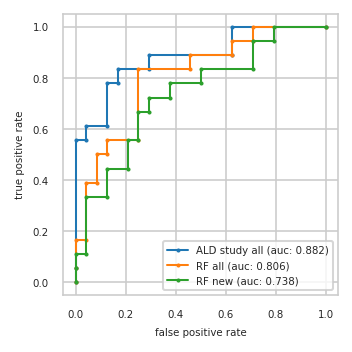

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.556  0.000 0.167  0.000 0.111
3          0.042 0.556  0.042 0.167  0.042 0.111
4          0.042 0.611  0.042 0.389  0.042 0.333
5          0.125 0.611  0.083 0.389  0.125 0.333
6          0.125 0.778  0.083 0.500  0.125 0.444
7          0.167 0.778  0.125 0.500  0.208 0.444
8          0.167 0.833  0.125 0.556  0.208 0.556
9          0.292 0.833  0.250 0.556  0.250 0.556
10         0.292 0.889  0.250 0.833  0.250 0.667
11         0.625 0.889  0.458 0.833  0.292 0.667
12         0.625 1.000  0.458 0.889  0.292 0.722
13         1.000 1.000  0.625 0.889  0.375 0.722
14           NaN   NaN  0.625 0.944  0.375 0.778
15           NaN   NaN  0.708 0.944  0.500 0.778
16           NaN   NaN  0.708 1.000  0.500 0.833
17           NaN   NaN  1.000 1.000  0.708 0.833
18           NaN   NaN    NaN   NaN  0.708 0.944
19           NaN   NaN    NaN   NaN  0.792 0.944
20           NaN   NaN    NaN   NaN  0.792 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q8NFY4;Q8NFY4-6,P09382,P51688
2,Q16674;W4VSR3,C9JIZ6;P07602;P07602-2;P07602-3,E7EPV7;P37840;P37840-2
3,P61981,F8WE04;P04792,Q96GD0
4,P04075,P10636-2;P10636-6,P31321
5,P14174,P04075,J3KSJ8;Q9UD71;Q9UD71-2
6,A0A0C4DGY8;D6RA00;Q9UHY7,P14174,O95497
7,P00338;P00338-3,Q14894,A0A075B7B8
8,Q6EMK4,P61981,E9PK25;G3V1A4;P23528


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


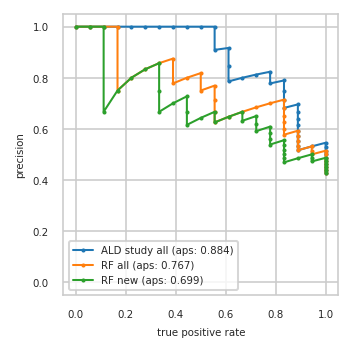

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.500 0.944     0.500 0.944
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.531 0.944     0.531 0.944     0.469 0.833
11         0.516 0.889     0.516 0.889     0.484 0.833
12         0.533 0.889     0.533 0.889     0.500 0.833
13         0.552 0.889     0.552 0.889     0.517 0.833
14         0.571 0.889     0.571 0.889     0.536 0.833
15         0.593 0.889     0.593 0.889     0.556 0.833
16         0.615 0.889     0.577 0.833     0.538 0.778
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.667 0.889     0.625 0.833     0.583 0.778
19         0.696 0.889     0.652 0.833     0.609 0.778
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.750 0.833     0.700 0.778     0.650 0.722
23         0.789 0.833     0.684 0.722     0.632 0.667
24         0.778 0.778     0.667 0.667     0.667 0.667
25         0.824 0.778     0.647 0.611     0.647 0.611
26         0.812 0.722     0.625 0.556     0.625 0.556
27         0.800 0.667     0.667 0.556     0.667 0.556
28         0.786 0.611     0.714 0.556     0.643 0.500
29         0.846 0.611     0.769 0.556     0.615 0.444
30         0.917 0.611     0.750 0.500     0.667 0.444
31         0.909 0.556     0.818 0.500     0.727 0.444
32         1.000 0.556     0.800 0.444     0.700 0.389
33         1.000 0.500     0.778 0.389     0.667 0.333
34         1.000 0.444     0.875 0.389     0.750 0.333
35         1.000 0.389     0.857 0.333     0.857 0.333
36         1.000 0.333     0.833 0.278     0.833 0.278
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


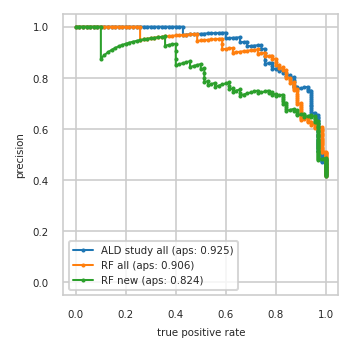

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


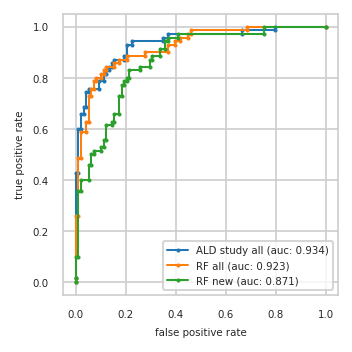

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}